# Libraries

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import glob
from scipy import stats
import datetime as dt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.layers import LSTM,Dropout,Dense

# Data Preparation

Data Preparation (9.1.1) ------------ Prepare same as 9.1.1 (8.1 (a) – (e) )------------------------------


In [54]:
# Load data from csv 3 files
# acceleration.txt, heartrate.txt, labeled_sleep.txt
ACC = pd.read_csv('46343_acceleration.txt', sep = ' ',names=['timedelta', 'accX', 'accY', 'accZ'])
HeartR = pd.read_csv('46343_heartrate.txt', sep = ',',names=['timedelta', 'heartrate'])
SleepL = pd.read_csv('46343_labeled_sleep.txt', sep = ' ',names=['timedelta', 'sleep'])

In [55]:
# Check ‘timedelta’ max(), min() of ACC, HeartR, SleepL (ช่วงเวลาที่มีข้อมูลใกล้กัน)
ACC_max_date = ACC['timedelta'].max()
ACC_min_date = ACC['timedelta'].min()
HeartR_max_date = HeartR['timedelta'].max()
HeartR_min_date = HeartR['timedelta'].min()
SleepL_max_date = SleepL['timedelta'].max()
SleepL_min_date = SleepL['timedelta'].min()
# หา start_timedelta, end_timedelta
print("Acc start    : "  + str(ACC_min_date) + " | Acc end    : " + str(ACC_max_date))
print("HeartR start : "  + str(HeartR_min_date) + " | HeartR end : " + str(HeartR_max_date))
print("SleepL start : "  + str(SleepL_min_date) + "             | SleepL end : " + str(SleepL_max_date))

Acc start    : -124489.16105 | Acc end    : 17643.046417
HeartR start : -556410.36066 | HeartR end : 16980.47229
SleepL start : 0             | SleepL end : 16980


In [56]:
# select only intersected timedelta (ACC, HeartR, SleepL) (ช่วงเวลาที่มีข้อมูลใกล้กัน)
# Ex
ACC_new = ACC[(ACC['timedelta'] > SleepL_min_date) & (ACC['timedelta'] < SleepL_max_date)]
HeartR_new = HeartR[(HeartR['timedelta'] > SleepL_min_date) & (HeartR['timedelta'] < SleepL_max_date)]
SleepL_new = SleepL[(SleepL['timedelta'] > SleepL_min_date) & (SleepL['timedelta'] < SleepL_max_date)]
ACC_new
# HeartR_new
# SleepL_new

,timedelta,accX,accY,accZ
98777,0.000721,-0.234650,0.905975,0.362747
98778,0.017162,-0.231232,0.893265,0.371613
98779,0.037183,-0.227814,0.915848,0.369049
98780,0.057108,-0.240524,0.919159,0.352890
98781,0.076929,-0.240448,0.889175,0.350143
...,...,...,...,...
948796,16979.905934,-0.442413,-0.527573,0.723450
948797,16979.925889,-0.441925,-0.527573,0.721985
948798,16979.945849,-0.441437,-0.526108,0.721985
948799,16979.965927,-0.443405,-0.525116,0.723434


In [57]:
# ------------ Rounding ACC (Rounding to 1 sec) -------------------------------
# Convert to datetime and round to second, 
ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))

# Average rounding duplicated time
df_acc_X = ACC_new.groupby('timedelta')['accX'].mean().reset_index() 
df_acc_Y = ACC_new.groupby('timedelta')['accY'].mean().reset_index()
df_acc_Z = ACC_new.groupby('timedelta')['accZ'].mean().reset_index()

# acc_X, acc_Y, acc_Z
ACC_new2 = pd.concat([df_acc_X, df_acc_Y, df_acc_Z], axis=1)
ACC_new2 = ACC_new2.loc[:,~ACC_new2.columns.duplicated()].copy()
ACC_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_3744\2152281988.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ACC_new['timedelta'] = pd.DataFrame(pd.to_timedelta(ACC_new['timedelta'], unit='s').round('1s'))


,timedelta,accX,accY,accZ
0,0 days 00:00:00,-0.243203,0.895372,0.367591
1,0 days 00:00:01,-0.240757,0.873826,0.415446
2,0 days 00:00:02,-0.244620,0.883943,0.387026
3,0 days 00:00:03,-0.248036,0.902427,0.347812
4,0 days 00:00:04,-0.241778,0.912946,0.321502
...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265


In [58]:
# ------------ Rounding Heart Rate (Rounding to 1 sec) -------------------------------
HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], unit= 's').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
HeartR_new2 = HeartR_new.set_index('timedelta').resample(resample_rule,).median().ffill()
HeartR_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_3744\2085734111.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HeartR_new['timedelta'] = pd.DataFrame(pd.to_timedelta(HeartR_new['timedelta'], unit= 's').round('1s'))


,heartrate
timedelta,
0 days 00:00:08,97.0
0 days 00:00:09,97.0
0 days 00:00:10,97.0
0 days 00:00:11,97.0
0 days 00:00:12,97.0
...,...
0 days 04:42:51,75.0
0 days 04:42:52,75.0
0 days 04:42:53,75.0


In [59]:
# ------------ Rounding Sleep Label (Rounding to 1 sec) -------------------------------
SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], unit= 's').round('1s'))

# Resampling every 1s with median with ffill
resample_rule = '1s'
SleepL_new2 = SleepL_new.set_index('timedelta').resample(resample_rule,).median().ffill()
SleepL_new2.replace({-1:0},inplace=True)
SleepL_new2

C:\Users\napat\AppData\Local\Temp\ipykernel_3744\858305284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SleepL_new['timedelta'] = pd.DataFrame(pd.to_timedelta(SleepL_new['timedelta'], unit= 's').round('1s'))


,sleep
timedelta,
0 days 00:00:30,0.0
0 days 00:00:31,0.0
0 days 00:00:32,0.0
0 days 00:00:33,0.0
0 days 00:00:34,0.0
...,...
0 days 04:42:26,0.0
0 days 04:42:27,0.0
0 days 04:42:28,0.0


In [60]:
# ------------Merge All Data -------------------------------
df = []
df = pd.merge_asof(ACC_new2, HeartR_new2, on = 'timedelta' )
df = pd.merge_asof(df, SleepL_new2, on = 'timedelta')
df

,timedelta,accX,accY,accZ,heartrate,sleep
0,0 days 00:00:00,-0.243203,0.895372,0.367591,NaN,NaN
1,0 days 00:00:01,-0.240757,0.873826,0.415446,NaN,NaN
2,0 days 00:00:02,-0.244620,0.883943,0.387026,NaN,NaN
3,0 days 00:00:03,-0.248036,0.902427,0.347812,NaN,NaN
4,0 days 00:00:04,-0.241778,0.912946,0.321502,NaN,NaN
...,...,...,...,...,...,...
16976,0 days 04:42:56,-0.442763,-0.525892,0.722950,76.0,0.0
16977,0 days 04:42:57,-0.441990,-0.525476,0.723410,76.0,0.0
16978,0 days 04:42:58,-0.441581,-0.525116,0.724003,76.0,0.0
16979,0 days 04:42:59,-0.442283,-0.525849,0.723265,76.0,0.0


In [61]:
# Fill NA
# Heart rate
# df.fillna() # using median()
hr_mean = df.heartrate.mean()
df.heartrate.fillna(hr_mean, inplace = True)
# Sleep Label
# df.fillna() # with 0
df.sleep.fillna(0, inplace = True)
# Drop column
df.drop(columns='timedelta',inplace=True)
df

,accX,accY,accZ,heartrate,sleep
0,-0.243203,0.895372,0.367591,80.886761,0.0
1,-0.240757,0.873826,0.415446,80.886761,0.0
2,-0.244620,0.883943,0.387026,80.886761,0.0
3,-0.248036,0.902427,0.347812,80.886761,0.0
4,-0.241778,0.912946,0.321502,80.886761,0.0
...,...,...,...,...,...
16976,-0.442763,-0.525892,0.722950,76.000000,0.0
16977,-0.441990,-0.525476,0.723410,76.000000,0.0
16978,-0.441581,-0.525116,0.724003,76.000000,0.0
16979,-0.442283,-0.525849,0.723265,76.000000,0.0


In [62]:
# Standardized data
feature_columns = ['accX', 'accY', 'accZ', 'heartrate']
label_columns = ['sleep']
standard_scaler = StandardScaler()
df[feature_columns] = standard_scaler.fit_transform(df[feature_columns])

df_feature = df[feature_columns] # <= standardized data of df_feature
df_label = df[label_columns]
df_feature

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.000000
1,-0.581456,2.995094,0.757746,0.000000
2,-0.591075,3.024668,0.722696,0.000000
3,-0.599581,3.078699,0.674335,0.000000
4,-0.583998,3.109450,0.641889,0.000000
...,...,...,...,...
16976,-1.084456,-1.096565,1.136974,-0.630391
16977,-1.082531,-1.095348,1.137542,-0.630391
16978,-1.081511,-1.094296,1.138273,-0.630391
16979,-1.083260,-1.096440,1.137363,-0.630391


(<AxesSubplot:>, <AxesSubplot:>)

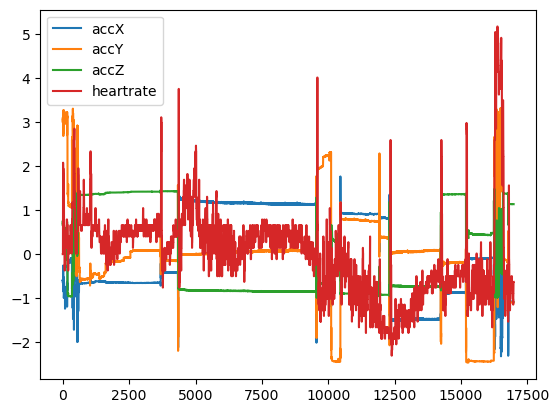

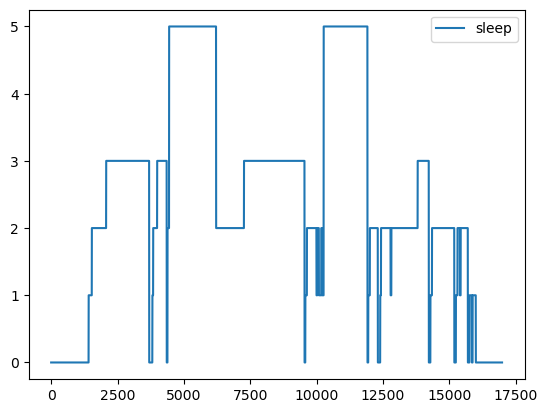

In [63]:
# Visualize signals
df_feature.plot(), df_label.plot()

Simple Moving Average (SMA) and Create 2D feature

In [64]:
# ------------Simple Moving Average (SMA) ------------------------------
# columns=['accX', 'accY', 'accZ', 'heartrate']

df_feature_SMA_accx = df_feature['accX'].rolling(5, min_periods=1).mean()
df_feature_SMA_accy = df_feature['accY'].rolling(5, min_periods=1).mean()
df_feature_SMA_accz = df_feature['accZ'].rolling(5, min_periods=1).mean()
df_feature_SMA_heartrate = df_feature['heartrate'].rolling(5, min_periods=1).mean()
df_feature_SMA = pd.concat([df_feature_SMA_accx,df_feature_SMA_accy,df_feature_SMA_accz,df_feature_SMA_heartrate], axis=1)
df_feature_SMA

,accX,accY,accZ,heartrate
0,-0.587547,3.058075,0.698728,0.000000
1,-0.584501,3.026584,0.728237,0.000000
2,-0.586693,3.025946,0.726390,0.000000
3,-0.589915,3.039134,0.713376,0.000000
4,-0.588732,3.053197,0.699079,0.000000
...,...,...,...,...
16976,-1.083093,-1.096081,1.137686,-0.707791
16977,-1.082878,-1.095794,1.137665,-0.681991
16978,-1.082621,-1.095441,1.137763,-0.656191
16979,-1.082981,-1.095685,1.137570,-0.630391


In [65]:
# ------------ Train-Test-Split 2D features -------------------------------
# set sliding window parameter
slidingW = 100 # จำนวน row
Stride_step = 5 
n_features = 4
Nsets = 0
df_feature2D = np.array([])
df_feature2D_T = np.array([])
df_label_new = np.array([])

for t in range( 0 , len(df_feature_SMA), Stride_step ):
    F2d = np.array(df_feature[ t : t + slidingW],ndmin=2)

    if len(F2d) < slidingW:
        break
    Nsets += 1
    df_feature2D = np.append(df_feature2D,F2d)
    F2d_T = np.transpose(F2d)
    df_feature2D_T = np.append(df_feature2D_T,F2d_T)

    Labels = stats.mode( df_label[t:t+slidingW])
    df_label_new = np.append(df_label_new,Labels[0])

df_feature2D = np.reshape(df_feature2D,(Nsets,slidingW,n_features))
df_feature2D_T = np.reshape(df_feature2D_T,(Nsets,n_features,slidingW))
df_feature2D.shape

C:\Users\napat\AppData\Local\Temp\ipykernel_3744\82644650.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  Labels = stats.mode( df_label[t:t+slidingW])


(3377, 100, 4)

In [66]:
df_feature2D_T.shape
df_label_new

array([0., 0., 0., ..., 0., 0., 0.])

Train Test Split

In [67]:
# ------------ Train-Test-Split 2D features -------------------------------
# OPTION 1  no transpose input_shape=(timesteps, n_features)
x_train, x_test, y_train, y_test = train_test_split( df_feature2D, df_label_new)

In [ ]:
# ------------ Train-Test-Split 2D features -------------------------------
# OPTION 2 with transpose input_shape=( n_features, timesteps)
x_train, x_test, y_train, y_test = train_test_split( df_feature2D_T, df_label_new)

# LSTM Model Training and Testing

LSTM Model Parameters

In [73]:
# try
#Option #1:
inRow = len(df_label_new)
inCol = slidingW

In [ ]:
# Option #2
inRow = slidingW
inCol = len(df_label_new)

In [80]:
# ------------ LSTM Architecture parameter -------------------------------
# Nlayer (LSTM, dense), Nnode, Activation
LSTM_L1 = 100 # try 200, 300, 400, 500, 1000 
LSTM_L2 = 50 # try 50, 100, 150, 200, 250, 300
dropRate_L1 = 0.25
dropRate_L2 = 0.5
D_out = 5
Activation = 'softmax'
n_classes = 6
Input_shape = (x_train.shape[1], x_train.shape[2])

LSTM Model Train Test

In [81]:
# ------------ Create LSTM Model -------------------------------
model = models.Sequential()
model.add(LSTM( LSTM_L1, return_sequences=True,input_shape=Input_shape))
model.add(Dropout(dropRate_L1 ))
model.add(LSTM(LSTM_L2 ))
model.add(Dropout(dropRate_L2))
model.add(Dense(n_classes, activation=Activation))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 100, 100)          42000     
                                                                 
 dropout_4 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 72,506
Trainable params: 72,506
Non-trainable params: 0
_________________________________________________________________


LSTM Model Train Test

In [82]:
# ------------ Create Optimizer -------------------------------
model.compile(  optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=["acc"])

In [83]:
# ------ Train CNN using 2D feature--------------------------------------------
# Training the model
EP = 50
batch_size = 60 # try 20, 40, 60, 80, 100
history = model.fit (   x_train, y_train, # try Option #1 และ Option #2
                        batch_size = batch_size, 
                        validation_data=(x_test, y_test), epochs=EP)


Epoch 1/50
43/43 [==============================] - 13s 198ms/step - loss: 1.2915 - acc: 0.4609 - val_loss: 0.9666 - val_acc: 0.5870
Epoch 2/50
43/43 [==============================] - 7s 153ms/step - loss: 0.9797 - acc: 0.5916 - val_loss: 0.9546 - val_acc: 0.5953
Epoch 3/50
43/43 [==============================] - 7s 157ms/step - loss: 0.9324 - acc: 0.6149 - val_loss: 0.8419 - val_acc: 0.6095
Epoch 4/50
43/43 [==============================] - 7s 152ms/step - loss: 0.8110 - acc: 0.6805 - val_loss: 0.6528 - val_acc: 0.7456
Epoch 5/50
43/43 [==============================] - 6s 150ms/step - loss: 0.8882 - acc: 0.6576 - val_loss: 0.7861 - val_acc: 0.6769
Epoch 6/50
43/43 [==============================] - 6s 149ms/step - loss: 0.7895 - acc: 0.6710 - val_loss: 0.7042 - val_acc: 0.6876
Epoch 7/50
43/43 [==============================] - 6s 149ms/step - loss: 0.7466 - acc: 0.6742 - val_loss: 0.6535 - val_acc: 0.6947
Epoch 8/50
43/43 [==============================] - 6s 151ms/step - loss: 0

# LSTM Performance Measurement

Performnace of LSTM Model

In [88]:
#LSTM prediction for Option #1 and Option #2
LSTM_pred = model.predict(x_test)
#Get classID from max prob(LSTM_pred)
df_pred = pd.DataFrame(LSTM_pred)
#df_class => use dataframe -> idxmax(axis=1)

LSTM_pred = np.argmax(model.predict(x_test),axis=1)
df_pred

27/27 [==============================] - 1s 43ms/step


,0,1,2,3,4,5
0,0.001164,0.000297,0.994045,0.004063,2.319277e-07,0.000432
1,0.001540,0.000567,0.101084,0.060265,5.332855e-05,0.836491
2,0.000091,0.000003,0.001538,0.998073,9.222809e-06,0.000285
3,0.000282,0.000014,0.005902,0.991986,1.892112e-05,0.001797
4,0.000324,0.000021,0.010994,0.986646,1.840237e-05,0.001996
...,...,...,...,...,...,...
840,0.002865,0.000569,0.994811,0.001567,2.368186e-07,0.000188
841,0.000332,0.000021,0.012579,0.985149,1.682323e-05,0.001903
842,0.001210,0.000406,0.077060,0.057910,4.421816e-05,0.863370
843,0.000099,0.000064,0.000437,0.000211,1.838534e-05,0.999171


In [89]:
# ------------ View Confusion Matrix, Classification Report -------------------------------
print('----- Confusion matrix of LSTM -----')
print(confusion_matrix(y_test,LSTM_pred))
print('----- Classification matrix of LSTM -----')
print(classification_report(y_test,LSTM_pred))

----- Confusion matrix of LSTM -----
[[119  10  10   0   1]
 [  7  27   3   0   3]
 [  0  16 198  24   4]
 [  0   0   3 230   0]
 [  0   1   1   0 188]]
----- Classification matrix of LSTM -----
              precision    recall  f1-score   support

         0.0       0.94      0.85      0.89       140
         1.0       0.50      0.68      0.57        40
         2.0       0.92      0.82      0.87       242
         3.0       0.91      0.99      0.94       233
         5.0       0.96      0.99      0.97       190

    accuracy                           0.90       845
   macro avg       0.85      0.86      0.85       845
weighted avg       0.91      0.90      0.90       845



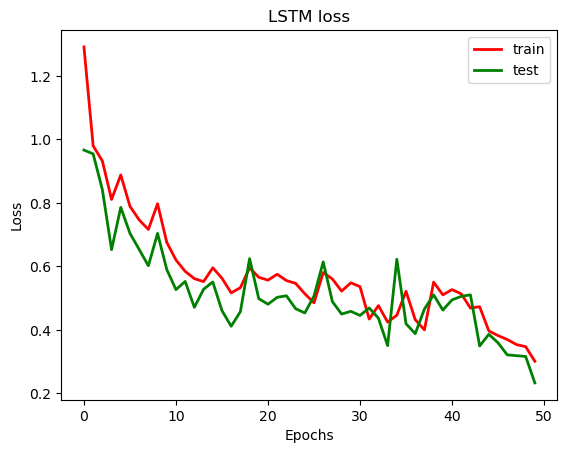

In [90]:
# # ------ View History Graph -------------------------------------------
# # View Accuracy Graph, Loss Graph
plt.plot(history.history['loss'],'r',linewidth=2,label ='train')
plt.plot(history.history['val_loss'],'g',linewidth =2 , label = 'test')
plt.title('LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

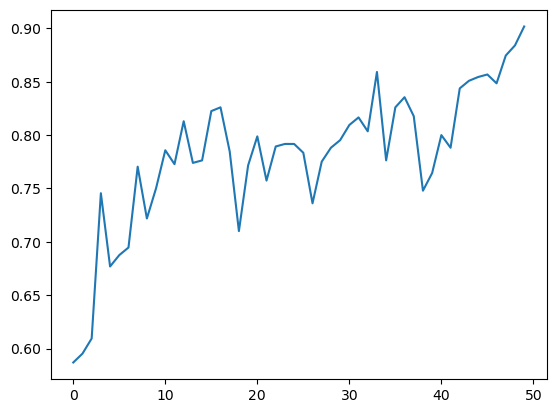

In [86]:
plt.plot(history.history['acc'],'r',linewidth=2,label ='train')
plt.plot(history.history['val_acc'],'g',linewidth =2 , label = 'test')
plt.title('LSTM accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()